# EDA for Wildfire detection - Part 4 (Understand kriging and rasters)
- Do more LR to understand more about CFSDS, and know how to estimate day of burning and extract covariates.
- Implement in Python Version.

## 1. About Kriging and Rasters.  

**Question: How the kriging and fire spread maps (rasters) actually calculate the wildfire detection delay?**  

---


According to the source materials, Kriging and rasters play a critical role in the construction of the Canadian Fire Spread Dataset (CFSDS).  

**Kriging**:
- Kriging is an interpolation method used to estimate values at unobserved locations based on observed data.

- In the context of the CFSDS, kriging is used to interpolate the timing of active fire detections, in order to estimate **the date the fire reached each pixel**. This interpolation result is referred to as the **“day-of-burning”** or **“fire arrival time.”**

- Researchers use the detection times (expressed as Julian day of year) of all active fire hotspots associated with an individual fire to fit a **variogram**, selecting the best-fitting model. Then, **ordinary kriging** is applied using the fire-specific variogram model to interpolate the fire arrival time across the fire perimeter.

**Rasters**:
- A raster is a geospatial data format that represents information as a grid or array of pixels, with each pixel holding a value representing a specific attribute of that location.

- In CFSDS, the result of fire arrival time interpolation is stored as a **fire arrival time raster**, with a resolution of **180 meters**. This raster is used to identify environmental covariates associated with fire behavior.

- Additionally, the CFSDS includes raster files such as **YEAR_NFIREID_krig.tif**, which represent the fire arrival time for a single fire. The pixel values indicate the **Julian day of year** the fire reached that 180-meter pixel. (For example, a value of 41 corresponds to February 10.)

**Considerations and Limitations When Using CFSDS**
> Understanding how satellite timing and zero-growth periods may impact the accuracy of fire arrival time interpolation.
- CFSDS also includes **zero-growth days**, which are days where no measurable fire spread occurred. The environmental covariates for these days are derived based on the spatial location of the next non-zero growth day. These **burning-day rasters** are uncalibrated and may be biased toward **nighttime detections**, which do not necessarily reflect the actual fire arrival time, as the most intense burning in Canadian wildfires usually occurs in the late afternoon or evening, when MODIS and VIIRS satellites are typically not overhead.

**Summary**:  
In summary, **kriging** is a spatial interpolation technique used to infer the precise fire arrival time at each location, while **rasters** are the gridded data structures that store both these arrival times and the related environmental variables. Together, they form the core components of the CFSDS.

## 2. How do Kriging and Rasters applied in CFSDS?
**Questions:**   
**2.1 How do kriging and fire spread maps (rasters) make use of the spectral bands, thermal infrared bands, thermal infrared channels, and thermal infrared bands that MODIS and VIIRS provide?**  
**2.2 How does this information connect with the aforementioned Kriging methods and "rasters"?**

---

### 2.1 Explain how kriging and fire spread maps (rasters) make use of the spectral bands, thermal infrared bands, and channels provided by MODIS and VIIRS.

Kriging and fire spread rasters in the **Canadian Fire Spread Dataset (CFSDS)** primarily rely on **active fire detection data (hotspots)** derived from the **Moderate Resolution Imaging Spectroradiometer (MODIS)** and the **Visible Infrared Imaging Radiometer Suite (VIIRS)**.

- **Use of Hotspots as Input Data**
    - The core of the CFSDS involves using MODIS and VIIRS active fire detections, referred to as **hotspots**, which represent **thermal anomalies captured by satellite sensors.**
    - According to the source, MODIS hotspot data are sourced from **Collection 6 MODIS datasets (MCD14ML, V006/V0061)**, which include both **Terra (MOD14)** and **Aqua (MYD14)** detections at a spatial resolution of **1 km**.
    - VIIRS hotspot data include detections from **Suomi-NPP (VNP14IMGT)** and **NOAA-20 (VJ114IMGTDL_NRT)** satellites, with a finer spatial resolution of **375 meters**.
    - These low-Earth orbit sensors collect multiple observations of active fires daily.
    - In total, the CFSDS integrates **3,731,070 hotspots** across Canada from **2002 to 2021**, sourced via **NASA FIRMS**.

- **How These Detections Are Used (Indirect Use of Spectral Information)**
    - **Hotspot detection times** serve as the primary input for kriging. For each individual wildfire, the detection times of all associated hotspots—expressed as decimal Julian days (e.g., February 1 at 12:00 PM is 32.5)—are used to fit a **variogram**.
    - **Time correction for observational bias** is applied: Because peak wildfire activity in Canada typically occurs in the late afternoon or evening—when MODIS and VIIRS are usually not overhead—this can introduce artificial delays in fire detection. To correct for this, any hotspots detected between **19:00 and 08:00** are reassigned to the **previous day** with a default detection time of **19:00**, based on the estimated post-peak Fire Radiative Power (FRP) from GOES-16 and GOES-17 satellites.
    - Using **ordinary kriging**, the interpolated fire arrival time is generated based on the fire-specific variogram fit. This spatial interpolation estimates the **“day of burning”** or **“fire arrival time”** for each unobserved pixel, based on surrounding hotspot detections.
    - The kriging results are stored in raster files (e.g., YEAR_NFIREID_krig.tif) with a spatial resolution of **180 meters**, where each pixel's value represents the Julian day of year when the fire reached that location.

- **Use of Spectral or Thermal Infrared Bands**
    - The sources **do not specify any direct use** of MODIS or VIIRS spectral bands, thermal infrared bands, or raw channel data in the kriging or raster generation process.
    - Instead, the datasets rely on **processed hotspot detections**, which are themselves derived from thermal infrared anomaly detection. Thus, it is implied that thermal infrared bands are foundational for generating the hotspots, but **kriging and raster generation work with these derived hotspots**, not the raw spectral data.
    - In other words, the interpolation and fire spread modeling use the **location and time of the detected hotspots**, rather than performing direct analysis on the underlying thermal imagery or spectral channels.


### 2.2 Explain how Kriging and Rasters applied in CFSDS

- The actual implementation in R looks like this:

    ``` r
    # 1. Build the empirical variogram from fire hotspot timestamps
    dob.kriged <- gstat::variogram(JDAYDEC ~ 1, hotspots)

    # 2. Fit the variogram using multiple candidate models: Exponential, Spherical, Matérn
    dob.fit <- fit.variogram(dob.kriged, vgm(c("Exp", "Sph", "Mat")))

    # 3. Apply ordinary kriging to interpolate fire arrival time across the fire perimeter
    dob.kriged <- krige(JDAYDEC ~ 1, hotspots, grid.pt, model = dob.fit, nmax = 6)
    ```
- The interpolation result is stored in a raster (e.g., firearrival_decimal_krig.tif), where each pixel holds a decimal-valued day-of-year representing the estimated fire arrival time. The values can later be truncated to integers (e.g., day 41 = February 10) for downstream processing.

- When evaluated against high-quality infrared fire perimeter observations, combining data from **VIIRS (Visible Infrared Imaging Radiometer Suite)** and **MODIS (Moderate Resolution Imaging Spectroradiometer)** with kriging or natural neighbor interpolation methods yields the most accurate estimates of fire arrival times.

**Summary**

In the CFSDS, kriging is used to interpolate the fire arrival time for each pixel based on hotspot detections derived from MODIS and VIIRS satellites. These hotspots, representing thermal anomalies detected via thermal infrared bands, serve as the input data for constructing fire spread maps.

Each fire’s hotspot detection times are used to fit a variogram and perform ordinary kriging, resulting in a fire arrival raster (180-meter resolution) where pixel values indicate the Julian day of year the fire arrived. Although MODIS and VIIRS collect thermal infrared data, the kriging process operates on processed hotspot products, not raw spectral bands.

To correct for detection timing bias, any hotspots observed between 19:00–08:00 are reassigned to the previous day to better match the actual peak fire activity, which often occurs in the late afternoon or evening.

Together, these techniques allow CFSDS to generate spatially continuous, time-sensitive fire spread data across large regions of Canada.

## 3. The next round of EDA based on the CFSDS data set. 
To evaluate the suitability of the CFSDS dataset, we conducted a basic Kriging interpolation using Python. The implementation was based on reference R code from the dataset, which we translated into Python for testing and exploration.

- Import all necessary libraries

In [ ]:
import os
import psutil
import geopandas as gpd
import rasterio
import rasterio.mask
import pandas as pd
import numpy as np
from shapely.geometry import mapping, Point, box
from scipy.interpolate import griddata
from datetime import datetime, timedelta
from pyproj import CRS as pyCRS
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from pyproj import CRS

- Import our own defined functions

In [ ]:
from krigLib import plot_kriging_with_perimeter_and_basegrid, blockwise_kriging, print_memory_usage, plot_perimeter_and_basegrid, show_shapefile_info, show_tif_info, plot_basegrid_cover_on_canada, plot_perimeter_and_basegrid_v2

### 3.1 Check the informations about all data sources needed for Kriging

- `basegrid`: We loaded the basegrid_180m.tif file to inspect its metadata and structure. It is a single-band raster with 180m resolution, uniform pixel values of 1, and covers an area of approximately 152 × 149 km.

=== GeoTIFF Info ===
File: ../data/CFSDS_example_Nov2023/basegrid_180m.tif
Driver: GTiff
Size: 845 x 829
Number of bands: 1
Data type: float32
CRS: PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-95],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-1783140.0, bottom=6996060.0, right=-1631040.0, top=7145280.0)
Pixel size: (180.0, 180.0)
NoData value: nan
Transform: | 180.00, 0.00,-1783140.00|
| 0.00,-180.00, 7145280.00|
| 0.00, 0.00, 1.00|

=== Real-world coverage ===
Width:

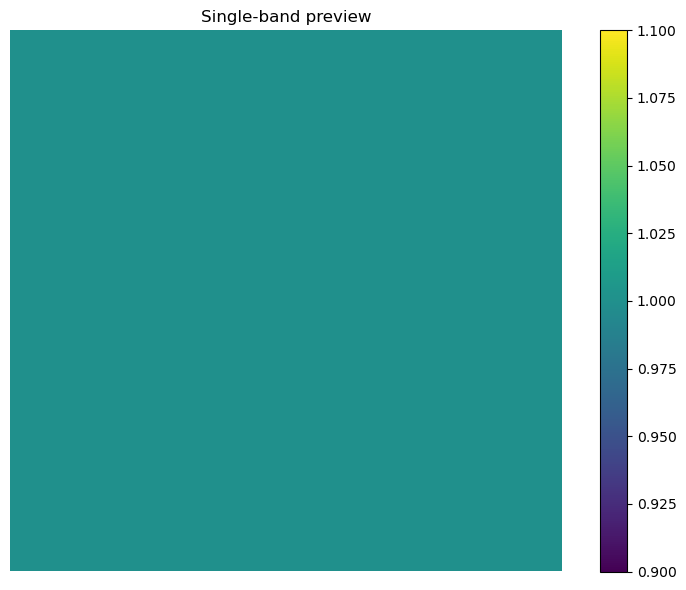

In [5]:
show_tif_info("../data/CFSDS_example_Nov2023/basegrid_180m.tif")

- The spatial extent of basegrid: We visualized the spatial extent of basegrid_180m.tif on a map of Canada. The red box shows the raster coverage, which is located in western Canada.

/Users/wangyunchen/conestoga1/CSCN8040-CaseStudies/wildfire_detection/src/krigLib.py:287: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper right')


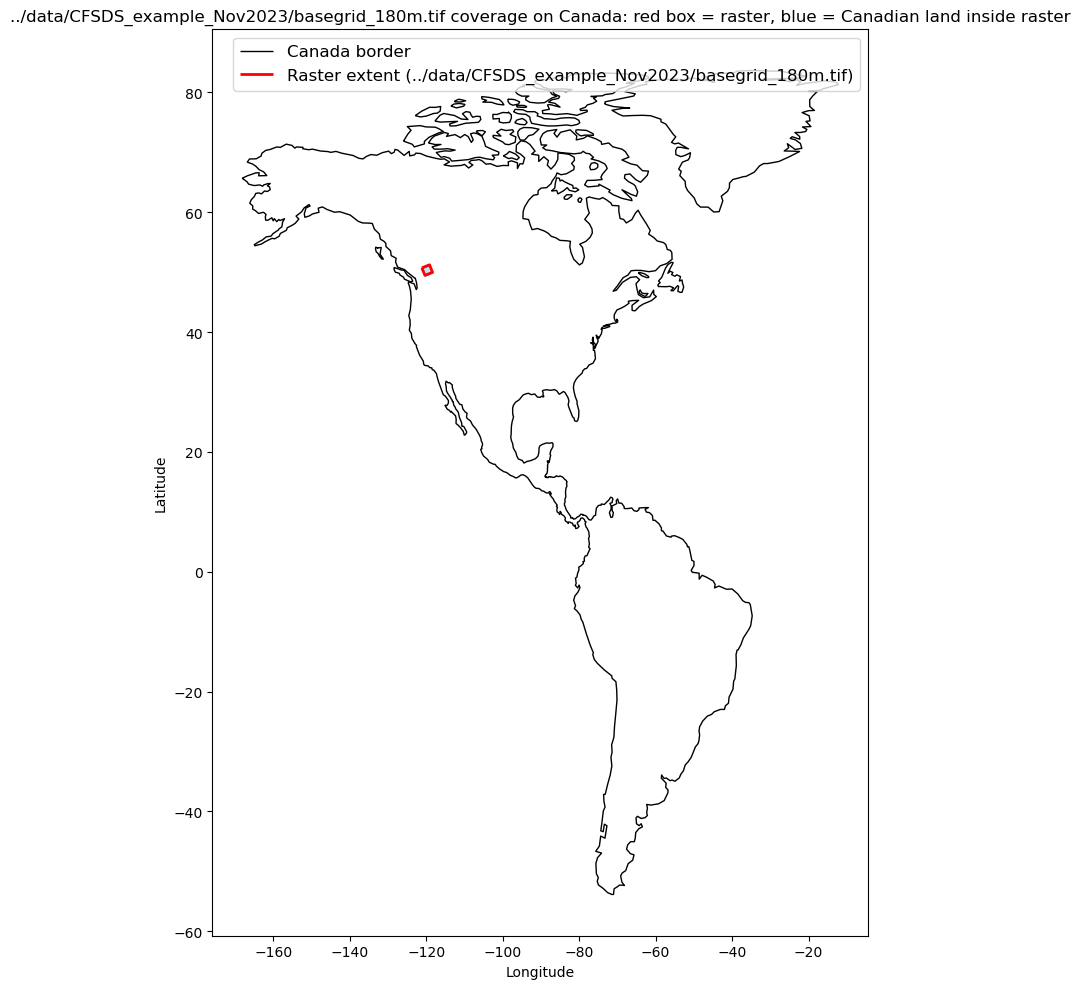

In [6]:
plot_basegrid_cover_on_canada("../data/CFSDS_example_Nov2023/basegrid_180m.tif")

- `perimeter`: We loaded the perimeter.shp shapefile, which represents the boundary of a specific fire event. The geometry is a multipolygon, and the preview confirms the fire perimeter's spatial extent.

=== Shapefile Info ===
File: ../data/CFSDS_example_Nov2023/perimeter.shp
Number of records: 1
CRS: PROJCS["Canada_Lambert_Conformal_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-95],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Geometry type(s): ['MultiPolygon']
Columns: ['YEAR', 'NFIREID', 'BASRC', 'FIREMAPS', 'FIREMAPM', 'FIRECAUS', 'BURNCLAS', 'SDATE', 'EDATE', 'AFSDATE', 'AFEDATE', 'CAPDATE', 'POLY_HA', 'ADJ_HA', 'ADJ_FLAG', 'AGENCY', 'BT_GID', 'VERSION', 'COMMENTS', 'geometry']

Sample rows:
     YEAR  NFIREID  BASRC  FIREMAPS  FIREMAPM  FIRECAUS  BU

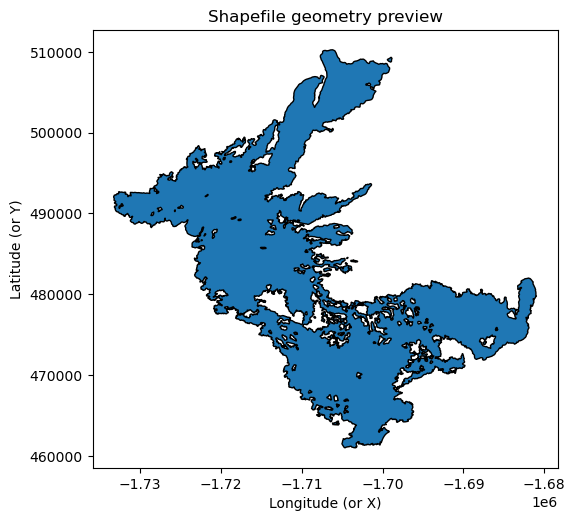

In [7]:
show_shapefile_info("../data/CFSDS_example_Nov2023/perimeter.shp")

- Visualize perimeter.shp and basegrid_180m.tif together:  
We overlaid the fire perimeter (blue) on the basegrid extent (red) to visualize the spatial relationship. The goal is to interpolate fire arrival times using hotspot data within the blue perimeter, covering the entire red basegrid area.
The goal of the interpolation is to use hotspot information within the blue fire perimeter (as defined by the perimeter shapefile) to estimate fire arrival times across the entire red basegrid area (from basegrid_180m.tif). This process generates predictions for every grid cell within the basegrid extent, including areas where no hotspots were directly observed.

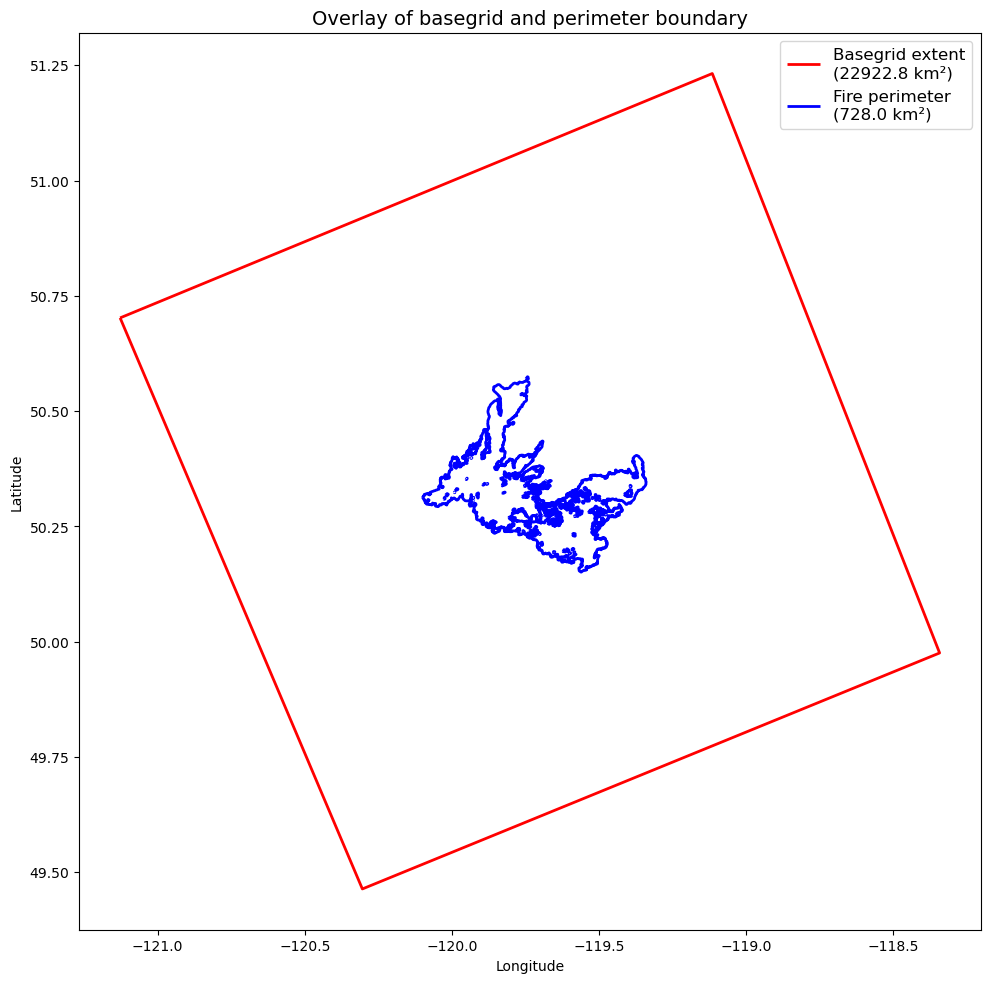

Basegrid area: 22922.84 km²
Perimeter area: 727.95 km²


In [8]:
plot_perimeter_and_basegrid("../data/CFSDS_example_Nov2023/perimeter.shp", "../data/CFSDS_example_Nov2023/basegrid_180m.tif")

### 3.2 Hotspots Preprocessing
Preprocessing includes perimeters and hotspots. Base grid should be in a projected coordinate system such as epsg:9001

- Read basegrid and fire perimeter shapefile

In [9]:
# Load basegrid and get its coordinate reference system
with rasterio.open('../data/CFSDS_example_Nov2023/basegrid_180m.tif') as basegrid:
    basegrid_crs = basegrid.crs

# Load fire perimeter shapefile and unify CRS
perimeter = gpd.read_file('../data/CFSDS_example_Nov2023/perimeter.shp')
perimeter['STARTDATE'] = pd.to_datetime(perimeter['AFSDATE'])
perimeter['ENDDATE'] = pd.to_datetime(perimeter['EDATE'])
perimeter = perimeter.to_crs(basegrid_crs)

- Time zone offset correction (Canada_Time_Zones)  
By overlaying the national time zone map with the fire perimeter, we can accurately identify which time zone the fire area falls into.

In [10]:
with rasterio.open('../data/CFSDS_example_Nov2023/basegrid_180m.tif') as src:
    _meta = src.meta.copy()

- Get the correct timezone offset

In [11]:
# Assume hotspots_gdf is already prepared (see previous step)
# Read time zone shapefile and reproject
timezone = gpd.read_file('../data/CFSDS_example_Nov2023/Canada_Time_Zones.shp').to_crs(_meta['crs'])

# Get time zone offset of the fire perimeter
fire_perimeter = gpd.read_file('../data/CFSDS_example_Nov2023/perimeter.shp').to_crs(_meta['crs'])
fire_timezone = gpd.overlay(fire_perimeter, timezone, how='intersection')
offset_col = 'LST_offset'  # Use actual field name
if 'LDT_offset' in fire_timezone.columns:
    offset_col = 'LDT_offset'
timezone_offset = fire_timezone[offset_col].astype(float).iloc[0]

- Integrate hotspot CSV files from MODIS/VIIRS

In [12]:
# Read hotspot CSV files and merge MODIS/VIIRS
modis_hotspots = pd.read_csv('../data/CFSDS_example_Nov2023/modis_2021_Canada.csv')
viirs_hotspots = pd.read_csv('../data/CFSDS_example_Nov2023/viirs-snpp_2021_Canada.csv')
viirs_hotspots.columns = modis_hotspots.columns  # Align column names
hotspots = pd.concat([modis_hotspots, viirs_hotspots], ignore_index=True)

# Convert date/time fields
hotspots['acq_date'] = pd.to_datetime(hotspots['acq_date'])
hotspots['JDAY'] = hotspots['acq_date'].dt.dayofyear  # Julian day
hotspots['ACQ_TIME'] = hotspots['acq_time'].astype(str).str.zfill(4)
hotspots['ACQ_TIME'] = hotspots['ACQ_TIME'].astype(float) / 2400
hotspots['YEAR'] = hotspots['acq_date'].dt.year
hotspots['JDAYDEC'] = hotspots['JDAY'] + hotspots['ACQ_TIME']

- Filter hotspots

In [13]:
# Use the first perimeter record (modify this loop if you have multiple fires)
fire = perimeter.iloc[0]
fire_start_year = fire['STARTDATE'].year
fire_start_jday = fire['STARTDATE'].dayofyear
fire_end_jday = fire['ENDDATE'].dayofyear

# Filter hotspots within date range (max 30 days after fire end)
hotspots_filtered = hotspots[
    (hotspots['YEAR'] == fire_start_year) &
    (hotspots['JDAY'] >= fire_start_jday - 30) &
    (hotspots['JDAY'] <= fire_end_jday + 30)
]

- Convert hotspot dataframe into GeoDataFrame (using World Geodetic System 1984)

In [14]:
# Convert to GeoDataFrame, assign coordinate system
geometry = [Point(xy) for xy in zip(hotspots_filtered['longitude'], hotspots_filtered['latitude'])]
hotspots_gdf = gpd.GeoDataFrame(hotspots_filtered, geometry=geometry, crs="EPSG:4326")  # WGS84 (World Geodetic System 1984)
hotspots_gdf = hotspots_gdf.to_crs(basegrid_crs)

In [15]:
# Correct JDAYDEC (decimal day of burning, corrected for time zone)
hotspots_gdf['JDAYDEC_corr'] = hotspots_gdf['JDAYDEC'] - timezone_offset/24

- Generate perimeter buffer

In [16]:
# Generate 1000 meter buffer around perimeter
perimeter_buf = perimeter.buffer(1000)

- Select hotspots within perimeter buffer

In [17]:
# Spatial query: select hotspots within perimeter buffer
hotspots_within_buf = hotspots_gdf[hotspots_gdf.within(perimeter_buf.unary_union)]

display(hotspots_within_buf.head())

/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_95918/30641873.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hotspots_within_buf = hotspots_gdf[hotspots_gdf.within(perimeter_buf.unary_union)]


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,bright_t31,frp,daynight,type,JDAY,ACQ_TIME,YEAR,JDAYDEC,geometry,JDAYDEC_corr
25057,50.3062,-120.0354,309.0,2.3,1.5,2021-07-14,506,Terra,MODIS,65,...,292.9,27.1,N,0,195,0.210833,2021,195.210833,POINT (-1729371.018 7074800.447),194.919167
25058,50.2991,-120.0642,333.7,2.3,1.5,2021-07-14,506,Terra,MODIS,100,...,296.9,110.4,N,0,195,0.210833,2021,195.210833,POINT (-1731558.198 7074858.202),194.919167
25059,50.3186,-120.0421,414.1,2.3,1.5,2021-07-14,506,Terra,MODIS,100,...,305.5,1137.3,N,0,195,0.210833,2021,195.210833,POINT (-1729283.132 7076250.209),194.919167
25060,50.3115,-120.0711,407.9,2.3,1.5,2021-07-14,506,Terra,MODIS,100,...,304.2,996.5,N,0,195,0.210833,2021,195.210833,POINT (-1731482.809 7076313.431),194.919167
25419,50.3094,-120.0312,326.8,3.6,1.8,2021-07-14,644,Terra,MODIS,100,...,292.7,169.5,N,0,195,0.268333,2021,195.268333,POINT (-1728960.202 7075013.408),194.976667


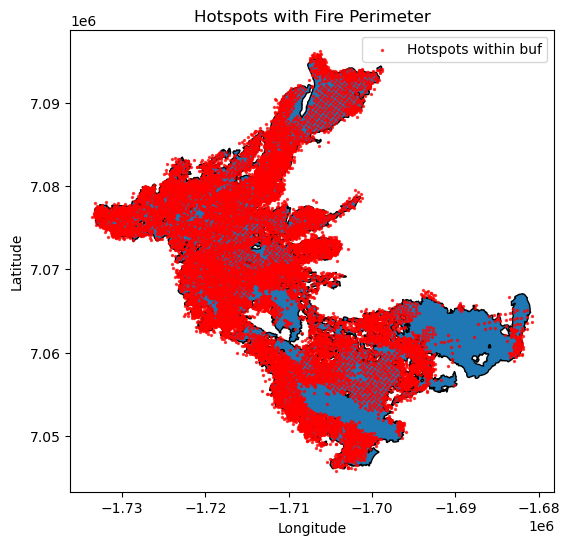

In [18]:
ax = perimeter.plot(edgecolor='black', linewidth=1, figsize=(8, 6))
hotspots_within_buf.plot(ax=ax, markersize=2, color='red', alpha=0.7, label='Hotspots within buf')
plt.title("Hotspots with Fire Perimeter")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

### 3.3 Interpolation
Here we use the subset hotspots and pre-defined perimeter to interpolate fire arrival time using kriging

- Read basegrid_180m.tif to get interpolation area information

In [19]:
# Prepare raster grid: Use basegrid as interpolation area ---
with rasterio.open('../data/CFSDS_example_Nov2023/basegrid_180m.tif') as src:
    meta = src.meta.copy()
    bounds = src.bounds
    width = src.width
    height = src.height
    transform = src.transform

#### Calculate grid cell center coordinates

- This block of code calculates the center coordinates of each raster (grid) cell. These coordinates are the points used for spatial interpolation (such as kriging).
All these points will later serve as the target locations for interpolation—that is, the area where you want to predict fire arrival time.

- Detailed Explanation
	1. xs = np.linspace(bounds.left + transform[0]/2, bounds.right - transform[0]/2, width)
		- Along the x-axis (longitude/easting), it starts from the raster’s left boundary plus half a pixel, and ends at the right boundary minus half a pixel, evenly divided into width points.
		- This ensures each value falls at the center of a grid cell.
	2. ys = np.linspace(bounds.top - transform[4]/2, bounds.bottom + transform[4]/2, height)
		- Similarly, along the y-axis (latitude/northing), it starts from the top boundary minus half a pixel and ends at the bottom boundary plus half a pixel, split into height points.
	3. xx, yy = np.meshgrid(xs, ys)
		- This creates a 2D meshgrid of all cell center coordinates (x, y pairs).
	4. grid_points = np.c_[xx.ravel(), yy.ravel()]
		- The 2D meshgrid is flattened into an N×2 array, where each row contains the (x, y) coordinates of a grid cell center.
---
In short:This produces a full list of the center points for every cell in your raster grid—these will be the locations where interpolation (such as kriging) is performed.

In [20]:
# Calculate grid cell center coordinates
xs = np.linspace(bounds.left + transform[0]/2, bounds.right - transform[0]/2, width)
ys = np.linspace(bounds.top - transform[4]/2, bounds.bottom + transform[4]/2, height)
xx, yy = np.meshgrid(xs, ys)
grid_points = np.c_[xx.ravel(), yy.ravel()]

#### Kriging Interpolation

About Kriging in this report:
1. Why do we still interpolate (kriging) at grid points that already have observed data? Will the original values be overwritten?
	•	Principle of kriging interpolation:
Kriging is a spatial interpolation method intended to estimate unknown values at grid points.
	•	However, in practical implementations, interpolation is often performed for the entire grid, including both known and unknown points.
	•	Will the known points be overwritten?
Yes, typically kriging will assign a predicted value to every grid cell, even those that coincide with observed points (“hotspots”).
	•	The interpolated result at these points will theoretically be very close to the original value (if you don’t exclude them from the sample, kriging at observed points ≈ observed value), but in code, all values get overwritten together.
	•	Why do it this way?
For convenience in data structure and visualization: this produces a complete map of fire arrival times across the entire study area.
	•	If you want to ensure the observed points are not overwritten by interpolation, you need to manually post-process: overwrite the predicted values with the original observed values at those grid locations.

---

2. In blockwise kriging, will predicted values from previous blocks be used to predict the next block?
	•	No!
	•	blockwise_kriging simply splits the grid into batches to reduce resource usage. Kriging is performed on each block independently.
	•	The predictions are always based solely on the 1500 hotspots_for_kriging sample points (the observed/known points).
	•	The predicted values from previous blocks are never used as inputs for predicting subsequent blocks.
	•	Each block uses the same set of known points—only the target grid cells differ between blocks.  
---



3. Does block_size affect accuracy, or only computation time/memory?
	•	It only affects computation time and memory usage, not interpolation accuracy!
	•	The accuracy is determined entirely by the number and spatial distribution of the known points (hotspots_for_kriging).
	•	Smaller block_size: fewer predictions per batch, slower but more stable, lower memory usage.
	•	Larger block_size: faster processing but requires more memory, risking a kernel crash if it exceeds system limits.
	•	The interpolation result will not change when you adjust block_size (assuming the code is implemented correctly).
	
---

Additional note: How to ensure observed values are never overwritten?
	•	After kriging, you can manually restore the original observed values to their corresponding grid locations (overwrite the predictions).
	•	This ensures that grid points with observed data retain their real values, while all others use the kriging predictions.

---


In [24]:
# Check total number of hotspots within buffer
total_hotspots = len(hotspots_within_buf)
print(f"Total hotspots within buffer: {total_hotspots}")

# Set sample size (number of points used for kriging)
sample_size = 1500

# Calculate sampling rate (percentage)
sampling_rate = sample_size / total_hotspots * 100
print(f"Sampling rate: {sampling_rate:.2f}%")

Total hotspots within buffer: 15074
Sampling rate: 9.95%


- Run Kriging

In [25]:
# Downsampling
hotspots_for_kriging = hotspots_within_buf.sample(12000, random_state=42)
# Get x, y, z for kriging (use only sampled points!)
hotspot_x = hotspots_for_kriging.geometry.x.values
hotspot_y = hotspots_for_kriging.geometry.y.values
hotspot_z = hotspots_for_kriging['JDAYDEC_corr'].values

# Run kriging function
z_pred = blockwise_kriging(hotspot_x, hotspot_y, hotspot_z, grid_points, block_size=10000)

Total grid points: 700505, processing 71 blocks of 10000 points each.
Block 1/71 done. Points 0 ~ 10000
Block 2/71 done. Points 10000 ~ 20000
Block 3/71 done. Points 20000 ~ 30000
Block 4/71 done. Points 30000 ~ 40000
Block 5/71 done. Points 40000 ~ 50000
Block 6/71 done. Points 50000 ~ 60000
Block 7/71 done. Points 60000 ~ 70000
Block 8/71 done. Points 70000 ~ 80000
Block 9/71 done. Points 80000 ~ 90000
Block 10/71 done. Points 90000 ~ 100000
Block 11/71 done. Points 100000 ~ 110000
Block 12/71 done. Points 110000 ~ 120000
Block 13/71 done. Points 120000 ~ 130000
Block 14/71 done. Points 130000 ~ 140000
Block 15/71 done. Points 140000 ~ 150000
Block 16/71 done. Points 150000 ~ 160000
Block 17/71 done. Points 160000 ~ 170000
Block 18/71 done. Points 170000 ~ 180000
Block 19/71 done. Points 180000 ~ 190000
Block 20/71 done. Points 190000 ~ 200000
Block 21/71 done. Points 200000 ~ 210000
Block 22/71 done. Points 210000 ~ 220000
Block 23/71 done. Points 220000 ~ 230000
Block 24/71 done. P

- Draw the Kriging interpolation results

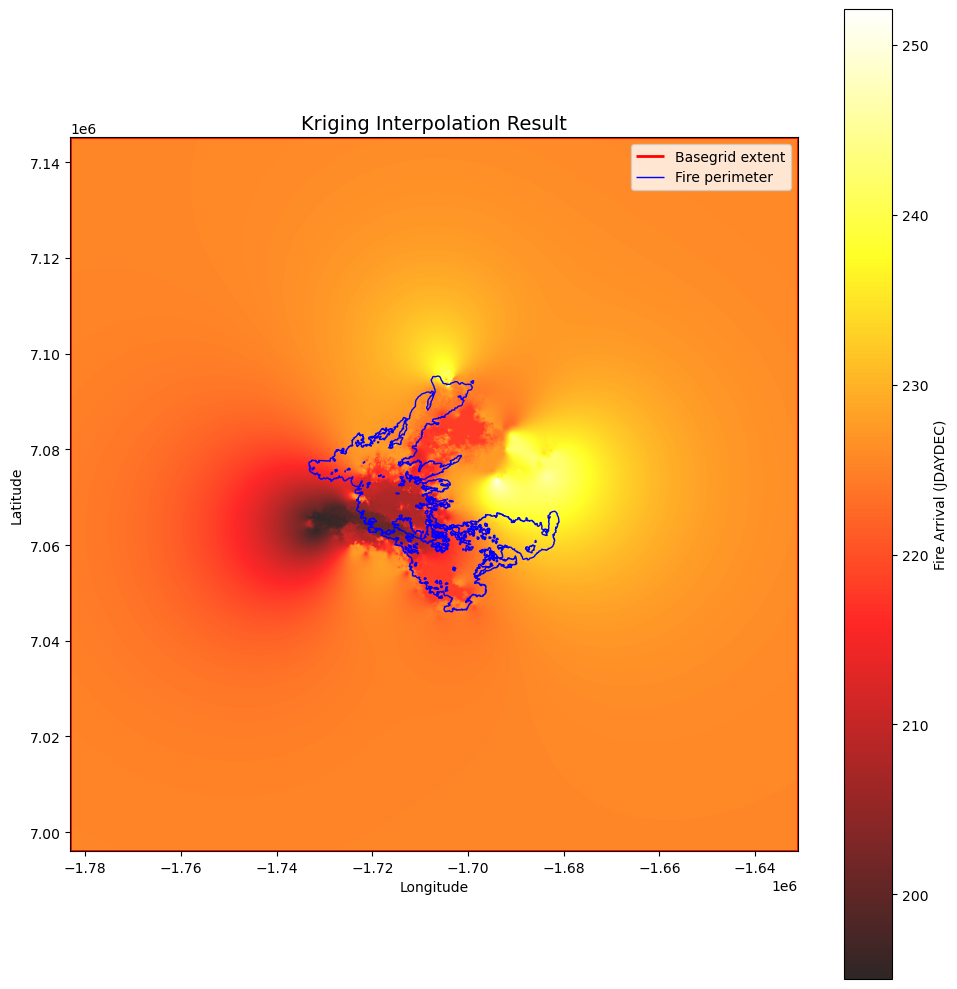

In [ ]:
plot_kriging_with_perimeter_and_basegrid(
    z_pred, height, width, "../data/CFSDS_example_Nov2023/basegrid_180m.tif", 
    "../data/CFSDS_example_Nov2023/perimeter.shp")

- Store the fire arrival values (Day of Burn) after Kriging interpolation:  
To maximize flexibility for future analysis and visualization, we store both the floored integer version and the original continuous (float) version of the Kriging output. The integer version is suitable for use cases requiring discrete fire arrival days, while the continuous version preserves all interpolated detail and can be post-processed as needed.

In [ ]:
# Save in float32 (the original value output from kriging)
with rasterio.open('../output/firearrival_jday_krig_float.tif', 'w', **meta) as dst: # jday: Julian day of year
    dst.write(z_pred.reshape(height, width), 1)

# Save in int (Since day of burn values are usually integers, we change the type into int.)
z_pred_int = np.floor(z_pred).astype('float32')
with rasterio.open('../output/firearrival_jday_krig_int.tif', 'w', **meta) as dst: # jday: Julian day of year
    dst.write(z_pred_int.reshape(height, width), 1)

# How to read the files?


- Read fire arrival raster

In [21]:
with rasterio.open('../output/firearrival_jday_krig_int.tif') as src:
    fire_arrival = src.read(1)

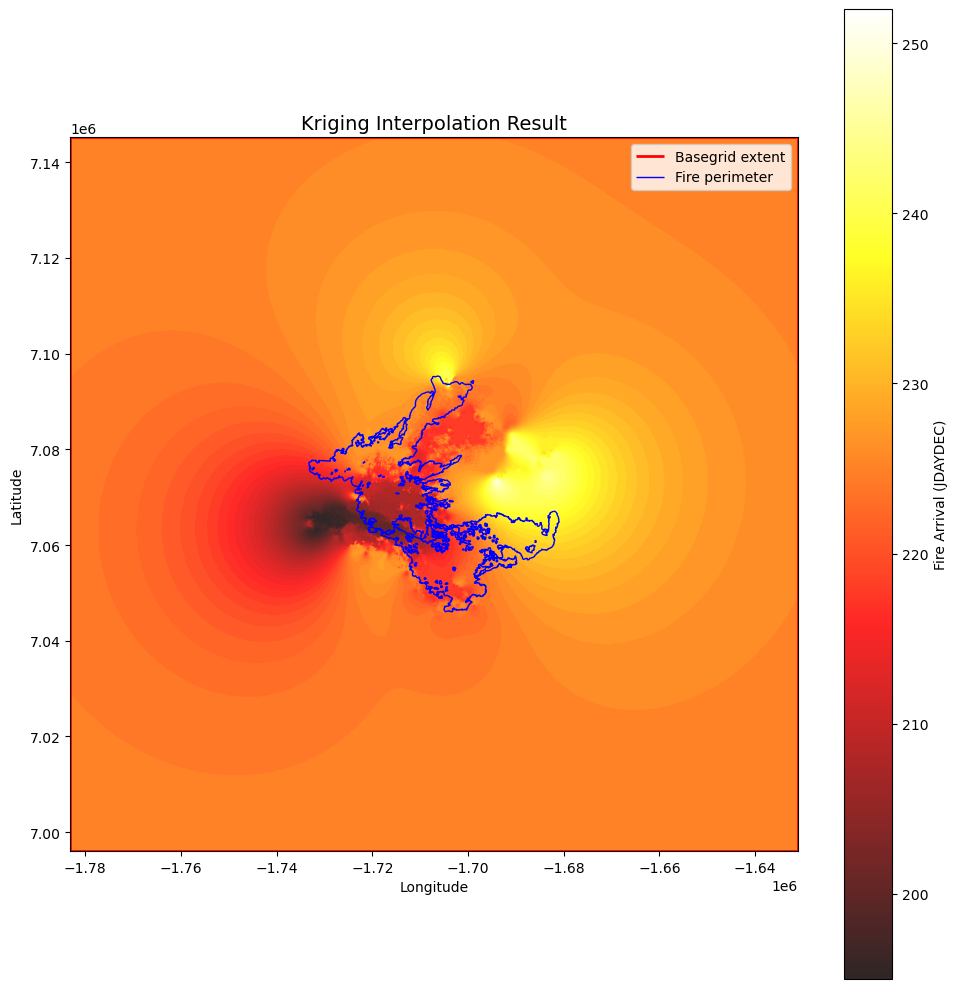

In [22]:
plot_kriging_with_perimeter_and_basegrid(
    fire_arrival, height, width, "../data/CFSDS_example_Nov2023/basegrid_180m.tif", 
    "../data/CFSDS_example_Nov2023/perimeter.shp")

- During the Kriging interpolation process, hotspot data located within the fire perimeter (the blue contour in the figure) is used to perform spatial interpolation across the entire basegrid area. The resulting interpolated values represent the estimated fire arrival day at each pixel (i.e., the day the fire reached each location, which can be further converted to a calendar date).
- In this figure, darker colors (towards black and red) indicate locations where the fire arrived earlier, while lighter colors (yellow to white) correspond to locations where the fire arrived later.

## 4. Future Work

An important direction for future work is to investigate whether the dataset, in combination with Kriging interpolation, can be used to accurately identify the likely ignition location(s) of wildfires. This would involve systematically examining the original hotspot records to determine the minimum fire arrival day (e.g., the earliest Julian day) and mapping this value spatially to estimate ignition points. Furthermore, by integrating additional environmental variables, it may be possible to infer the probable causes of ignition or to assess correlations between ignition locations and specific environmental conditions. Finally, a more detailed analysis of detection latency—such as the time lag between the actual fire start and the earliest detected hotspot—could help evaluate the effectiveness of current monitoring systems and inform improvements in early wildfire detection.